<a href="https://colab.research.google.com/github/macwolfz/DZDeepLearningCancerClassification/blob/main/SCCvsACA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [7]:
import os
import glob
import pathlib
#from shutil import copyfile
import shutil
from sys import exit
import matplotlib.pyplot as plt
from shutil import copyfile
#import keras.backend.tensorflow_backend as tfback

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [9]:
import pydotplus
import graphviz

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
num_skipped = 0
for folder_name in ("lung_aca", "lung_scc"):
    folder_path = os.path.join("/content/gdrive/MyDrive/Tesis/Datasets/solo_cancer_pulmon", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)
#

Deleted 0 images


In [11]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Tesis/Datasets/solo_cancer_pulmon",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Tesis/Datasets/solo_cancer_pulmon",
    validation_split=0.2,
    subset="validation",
    #seed=1337,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)


Found 7355 files belonging to 2 classes.
Using 5884 files for training.
Found 7355 files belonging to 2 classes.
Using 1471 files for validation.


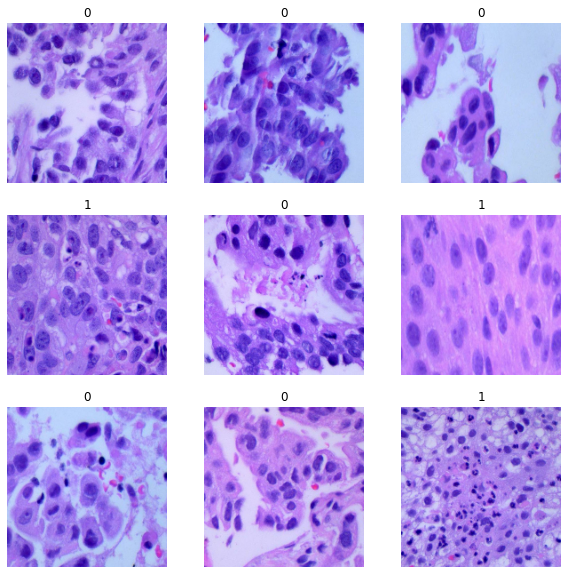

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [14]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

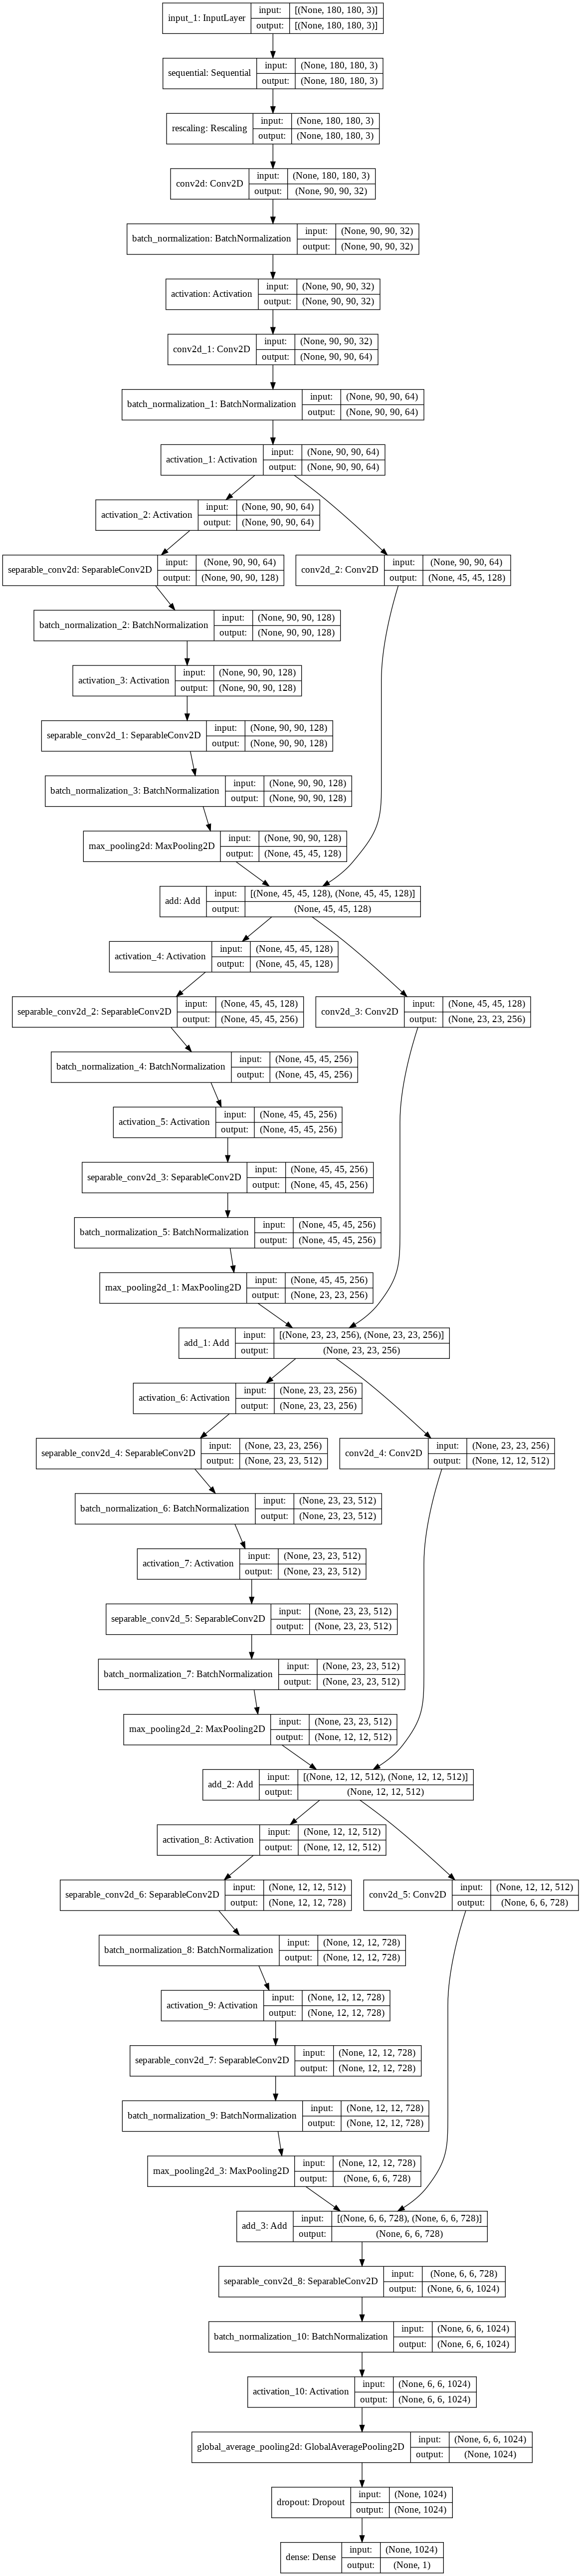

In [15]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [17]:
epochs = 80
callbacks = [
    keras.callbacks.ModelCheckpoint("/content/gdrive/MyDrive/Tesis/Models/CancerACAvsSCC/ADAMsave_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    #optimizer="AdaGrad",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
hist = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/80
184/184 [==============================] - 55s 286ms/step - loss: 0.2779 - accuracy: 0.8824 - val_loss: 3.0813 - val_accuracy: 0.5037
Epoch 2/80
184/184 [==============================] - 51s 273ms/step - loss: 0.1843 - accuracy: 0.9276 - val_loss: 5.3196 - val_accuracy: 0.5037
Epoch 3/80
184/184 [==============================] - 51s 271ms/step - loss: 0.1585 - accuracy: 0.9341 - val_loss: 0.2103 - val_accuracy: 0.9286
Epoch 4/80
184/184 [==============================] - 51s 272ms/step - loss: 0.1172 - accuracy: 0.9558 - val_loss: 0.2135 - val_accuracy: 0.9157
Epoch 5/80
184/184 [==============================] - 52s 276ms/step - loss: 0.1190 - accuracy: 0.9520 - val_loss: 1.4792 - val_accuracy: 0.7410
Epoch 6/80
184/184 [==============================] - 52s 277ms/step - loss: 0.1004 - accuracy: 0.9575 - val_loss: 0.1077 - val_accuracy: 0.9551
Epoch 7/80
184/184 [==============================] - 52s 277ms/step - loss: 0.0790 - accuracy: 0.9688 - val_loss: 1.1595 - val_ac

**Load** Epoch 48/50
206/206 [==============================] - 121s 585ms/step - loss: 0.0386 - accuracy: 0.9853 - val_loss: 0.0577 - val_accuracy: 0.9787


In [ ]:
from tensorflow.keras.models import load_model
new_model = load_model('')
#new_model.summary()
#new_model.get_weights()

In [30]:
img = keras.preprocessing.image.load_img(
    #"/content/gdrive/MyDrive/Tesis/Datasets/pulmon/LungDS/lungscc367.jpeg", target_size=image_size
    "/content/gdrive/MyDrive/Tesis/Datasets/Tests/SCCvsACA/input/lungaca4696.jpeg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent ACA and %.2f percent SCC."
    % (100 * (1 - score), 100 * score)
)

This image is 100.00 percent ACA and 0.00 percent SCC.


In [31]:
pred_path='/content/gdrive/MyDrive/Tesis/Datasets/Tests/SCCvsACA/input'
#categories
images_path=glob.glob(pred_path+'/*.jpeg')

In [32]:
target_cancer = "/content/gdrive/MyDrive/Tesis/Datasets/Tests/SCCvsACA/output/aca"
target_no_cancer = "/content/gdrive/MyDrive/Tesis/Datasets/Tests/SCCvsACA/output/scc"
target_others = "/content/gdrive/MyDrive/Tesis/Datasets/Tests/SCCvsACA/output/others"

In [36]:
num_aca_cancer = 0
num_scc_cancer = 0
num_otros = 0
predictions={}

for i in images_path:
    img = keras.preprocessing.image.load_img(
    i, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)
    #predictions = model.predict(img_array)
    score = predictions[0]
    res = i.partition(pred_path)[2]
    print(res[1:])
    if "lungscc" in res and (100 * score)>50:
        print("Squamous Carcinoma")
        num_scc_cancer += 1
        # adding exception handling
        try:
            copyfile(i, target_no_cancer+res)
        except IOError as e:
            print("Unable to copy file. %s" % e)
            exit(1)
        except:
            print("Unexpected error:", sys.exc_info())
            exit(1)
            
    elif "lungscc" not in res and (100*(1-score))> 50:
        print("Adenocarcinoma")
        num_aca_cancer+=1
        # adding exception handling
        try:
            copyfile(i, target_cancer+res)
        except IOError as e:
            print("Unable to copy file. %s" % e)
            exit(1)
        except:
            print("Unexpected error:", sys.exc_info())
            exit(1)
    else:
        print("ERROR")
        print(100*score)
        print(100*(1-score))
        num_otros += 1
        # adding exception handling
        try:
            copyfile(i, target_others+res)
        except IOError as e:
            print("Unable to copy file. %s" % e)
            exit(1)
        except:
            print("Unexpected error:", sys.exc_info())
            exit(1)
                               
    print(
    "This image is %.2f percent ACA and %.2f percent SCC."
    % (100 * (1 - score), 100 * score)
    )
    print("\n")
   


Streaming output truncated to the last 5000 lines.

lungaca4503.jpeg
Adenocarcinoma
This image is 99.91 percent ACA and 0.09 percent SCC.


lungaca4502.jpeg
Adenocarcinoma
This image is 100.00 percent ACA and 0.00 percent SCC.


lungaca4501.jpeg
Adenocarcinoma
This image is 99.99 percent ACA and 0.01 percent SCC.


lungn4501.jpeg
Adenocarcinoma
This image is 100.00 percent ACA and 0.00 percent SCC.


lungaca5000.jpeg
Adenocarcinoma
This image is 100.00 percent ACA and 0.00 percent SCC.


lungaca4999.jpeg
Adenocarcinoma
This image is 100.00 percent ACA and 0.00 percent SCC.


lungaca4998.jpeg
Adenocarcinoma
This image is 99.99 percent ACA and 0.01 percent SCC.


lungaca4995.jpeg
Adenocarcinoma
This image is 100.00 percent ACA and 0.00 percent SCC.


lungaca4997.jpeg
Adenocarcinoma
This image is 99.91 percent ACA and 0.09 percent SCC.


lungaca4996.jpeg
Adenocarcinoma
This image is 100.00 percent ACA and 0.00 percent SCC.


lungaca4994.jpeg
Adenocarcinoma
This image is 100.00 percent ACA

In [37]:
print("腺癌（ACA）：",num_aca_cancer)
print("鳞状细胞癌（SCC）：",num_scc_cancer)
print("另外的图片：",num_otros)

腺癌（ACA）： 500
鳞状细胞癌（SCC）： 499
另外的图片： 2


In [ ]:
import glob, os, os.path

filelist = glob.glob(os.path.join("/content/gdrive/MyDrive/Tesis/Datasets/Tests/SCCvsACA/output/aca", "*.jpeg"))
for f in filelist:
    os.remove(f)
filelist = glob.glob(os.path.join("/content/gdrive/MyDrive/Tesis/Datasets/Tests/SCCvsACA/output/scc", "*.jpeg"))
for f in filelist:
    os.remove(f)
filelist = glob.glob(os.path.join("/content/gdrive/MyDrive/Tesis/Datasets/Tests/SCCvsACA/output/others", "*.jpeg"))
for f in filelist:
    os.remove(f)



In [39]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)
print('\nTest Accuracy', test_acc)

46/46 - 6s - loss: 0.0118 - accuracy: 0.9952

Test Accuracy 0.9952413439750671


In [40]:
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [49]:
#Start
train_data_path = '/content/gdrive/MyDrive/Tesis/Datasets/solo_cancer_pulmon'
test_data_path = '/content/gdrive/MyDrive/Tesis/Datasets/Tests/SCCvsACA/input'
img_rows = 180
img_cols = 180
epochs = 30
batch_size = 32
num_of_train_samples = 4334
num_of_test_samples = 1448

#Image Generator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(train_data_path,
                                                        target_size=(img_rows, img_cols),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

img_height, img_width = (180,180)
batch_size = 32

train_data_dir = r"/content/gdrive/MyDrive/Tesis/Datasets/solo_cancer_pulmon"
test_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_height, img_width),
    batch_size = 1, # aqui va 1 siempre
    class_mode="categorical",
    subset='validation') #set as validaton data
    

Found 7355 images belonging to 2 classes.
Found 7355 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [50]:
#Confution Matrix and Classification Report METHOD 1
val_steps_size = np.math.ceil(validation_generator.samples / validation_generator.batch_size)
Y_pred = model.predict(validation_generator)
#Y_pred = model.predict_generator(validation_generator , num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator .classes, y_pred))
print('Classification Report')
target_names = ['lung_scc', 'lung_aca']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


Confusion Matrix
[[3669    0]
 [3686    0]]
Classification Report
              precision    recall  f1-score   support

    lung_scc       0.50      1.00      0.67      3669
    lung_aca       0.00      0.00      0.00      3686

    accuracy                           0.50      7355
   macro avg       0.25      0.50      0.33      7355
weighted avg       0.25      0.50      0.33      7355



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
